# Modeling for xG-NextGen Project

This notebook builds, evaluates, and explains an improved expected goals (xG) model using XGBoost. The model incorporates spatial, contextual, and defensive pressure features to provide more accurate shot outcome predictions.

## Import Libraries

Load required Python packages for modeling, evaluation, and explanation. We use XGBoost for its efficiency with structured data, SHAP for model interpretability, and scikit-learn for evaluation metrics.

In [ ]:
!pip install pandas numpy xgboost scikit-learn shap matplotlib seaborn

In [ ]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
import pickle  # for saving model

# Set visualization style
sns.set()  # uses seaborn default style
shap.initjs()

## Load Feature Data

Import the engineered features from previous processing steps. This dataset contains spatial, contextual, and defensive pressure features along with the target variable (goal/no goal).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

features_path = '/content/drive/MyDrive/xG-NextGen/data/processed/features.csv'
df = pd.read_csv(features_path)
print(f"Loaded features data: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Goal rate: {df['goal'].mean():.2%}")

Mounted at /content/drive
Loaded features data: (87111, 18)
Columns: ['goal_difference', 'is_home', 'n_prev_passes', 'minute', 'distance', 'angle', 'angular_pressure', 'body_part_Left Foot', 'body_part_Other', 'body_part_Right Foot', 'shot_type_Free Kick', 'shot_type_Kick Off', 'shot_type_Open Play', 'shot_type_Penalty', 'abs_goal_diff', 'defenders_in_5m', 'gk_distance', 'goal']
Goal rate: 11.10%


## Prepare Data for Modeling

Define the target variable and feature matrix. We split the data into training (80%) and testing (20%) sets while preserving the class distribution through stratified sampling. This ensures our model evaluation reflects real-world performance.

In [ ]:
y = df['goal']
X = df.drop(['goal'], axis=1)
# Ensure only numeric features for modeling & SHAP
X = X.select_dtypes(include=[np.number])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Training: {X_train.shape}, Testing: {X_test.shape}")

Training: (69688, 10), Testing: (17423, 10)


## Train XGBoost Model

Initialize and train an XGBoost classifier. We use log loss as the evaluation metric to optimize for probability calibration. The model is trained with default hyperparameters for initial benchmarking, with regularization to prevent overfitting.

In [ ]:
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    reg_alpha=0.1,
    reg_lambda=1
)
print("Training model...")
model.fit(X_train, y_train)
print("Model training complete")

Training model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:12:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training complete


## Evaluate Model Performance

Assess model quality using AUC-ROC to measure discrimination ability and a calibration curve to evaluate probability accuracy. AUC-ROC quantifies how well the model ranks shots by likelihood, while calibration ensures predicted probabilities match observed frequencies.

AUC-ROC: 0.8776
Brier score: 0.0686
Log loss: 0.2361


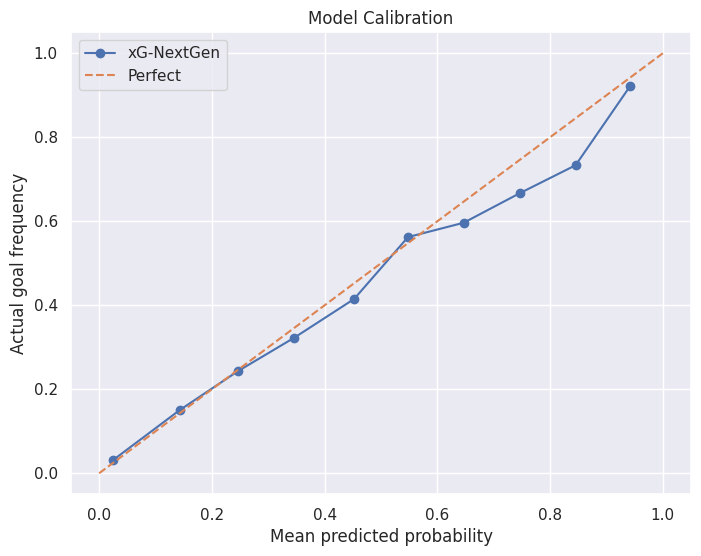

Saved calibration plot to /content/drive/MyDrive/xG-NextGen/outputs/charts/calibration_plot.png


In [ ]:
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
from sklearn.calibration import calibration_curve

# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# AUC-ROC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc:.4f}")

# Brier score
brier = brier_score_loss(y_test, y_pred_proba)
print(f"Brier score: {brier:.4f}")

# Log loss
lloss = log_loss(y_test, y_pred_proba)
print(f"Log loss: {lloss:.4f}")

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='xG-NextGen')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect')
plt.xlabel('Mean predicted probability')
plt.ylabel('Actual goal frequency')
plt.title('Model Calibration')
plt.legend()
plt.grid(True)
cal_path = '/content/drive/MyDrive/xG-NextGen/outputs/charts/calibration_plot.png'
os.makedirs(os.path.dirname(cal_path), exist_ok=True)
plt.savefig(cal_path, bbox_inches='tight', dpi=300)
plt.show()
print(f"Saved calibration plot to {cal_path}")

## Save Trained Model

Persist the trained model to disk for future use in predictions and applications. The model is saved in XGBoost's native format for efficient loading during deployment.

In [ ]:
model_path = '/content/drive/MyDrive/xG-NextGen/models/xgboost_model.json'
model.save_model(model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/xG-NextGen/models/xgboost_model.json


## SHAP Analysis

Perform SHAP (SHapley Additive exPlanations) analysis to interpret model predictions. SHAP values quantify feature importance and directionality, providing insights into how each feature influences xG predictions at both global and individual shot levels.

Computing SHAP values...


 99%|===================| 17242/17423 [01:26<00:00]       

SHAP values saved to /content/drive/MyDrive/xG-NextGen/outputs/shap_values/shap_values.csv


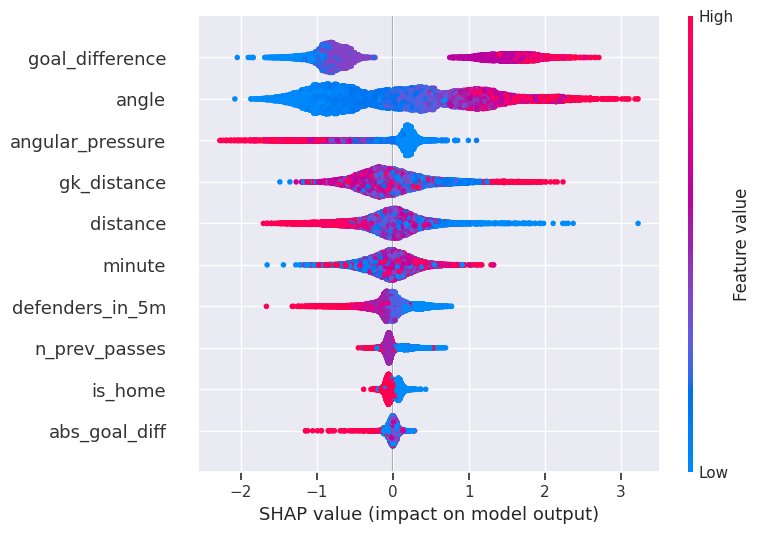

SHAP summary plot saved to /content/drive/MyDrive/xG-NextGen/outputs/shap_values/shap_summary.png


In [ ]:
explainer = shap.Explainer(model, X_train)
print("Computing SHAP values...")
shap_values = explainer(X_test)

shap_values_path = '/content/drive/MyDrive/xG-NextGen/outputs/shap_values/shap_values.csv'
os.makedirs(os.path.dirname(shap_values_path), exist_ok=True)
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df.to_csv(shap_values_path, index=False)
print(f"SHAP values saved to {shap_values_path}")

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
summary_path = '/content/drive/MyDrive/xG-NextGen/outputs/shap_values/shap_summary.png'
plt.savefig(summary_path, bbox_inches='tight', dpi=300)
plt.show()
print(f"SHAP summary plot saved to {summary_path}")

## Model Insights

Review key findings from the modeling process. The SHAP summary reveals which features most significantly impact xG predictions, while the AUC-ROC quantifies overall model performance.

In [ ]:
print("\nKey Performance Metrics")
print(f"- AUC-ROC: {auc:.4f}")
mean_shap = pd.Series(np.abs(shap_values.values).mean(axis=0), index=X_test.columns)
print("\nTop Features by Impact (SHAP magnitude):")
print(mean_shap.sort_values(ascending=False).head(10))


Key Performance Metrics
- AUC-ROC: 0.8776

Top Features by Impact (SHAP magnitude):
goal_difference     1.048836
angle               0.821283
angular_pressure    0.321809
gk_distance         0.317663
distance            0.293770
minute              0.211329
defenders_in_5m     0.170816
n_prev_passes       0.084427
is_home             0.066537
abs_goal_diff       0.043283
dtype: float64
